In [1]:
# Импортируем необходимые библиотеки
from Models.DecisionTree import MyTreeReg, TreeNode, mse, msep
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import date
import seaborn as sns
import itertools
from time import time
import holidays
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Идентификатор проекта и учетные данные для доступа к Google BigQuery
project_id = 'kolesa-android-app'
credentials = 'kolesa-android-app-715adc9bdf26.json'
credentials = service_account.Credentials.from_service_account_file(credentials)
# Запрос данных из Google BigQuery
q = "SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"
data = pd.read_gbq(q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type = 'tqdm')
#data = pd.read_csv('Data/data.csv')
data.head()

Downloading: 100%|█████████████████████████████████████████████████████████████|


,event_date,y
0,2020-01-01,5721
1,2020-01-02,8274
2,2020-01-03,9344
3,2020-01-04,9864
4,2020-01-05,10435


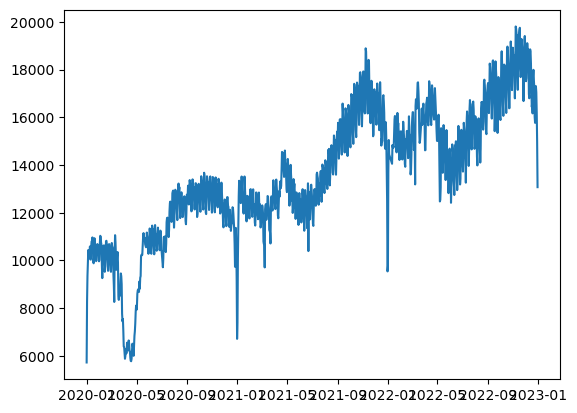

In [3]:
# Удаление дублирующихся строк и фильтрация данных на основе определенных условий
data = data.drop_duplicates()
data = data.drop(data[data['y'] > 1000000].index)
data = data.drop(data[data['y'] < 5000].index)
data.columns = ['ds', 'y']
data['ds'] = pd.to_datetime(data['ds'])
data = data.drop(data.query('ds == "2022-01-10"').index)
data = data.drop(data.query('ds == "2022-12-31"').index)
plt.plot(data['ds'], data['y'])

In [4]:
# Определение функций для выявления периодов Рамадана и коронавируса
def ramadan(ds):
    date = pd.to_datetime(ds)
    return (date >= pd.to_datetime('2020-04-24') and date<= pd.to_datetime('2020-05-24')
           or date >= pd.to_datetime('2021-04-13') and date<= pd.to_datetime('2021-05-13')
           or date >= pd.to_datetime('2022-04-03') and date<= pd.to_datetime('2022-05-03')
           or date >= pd.to_datetime('2023-03-23') and date <= pd.to_datetime('2023-04-24'))
def corona(ds):
    date = pd.to_datetime(ds)
    return (date >= pd.to_datetime('2020-03-18') and date<= pd.to_datetime('2020-05-11'))
# Применение функций для создания новых столбцов, указывающих периоды Рамадана и коронавируса
data['is_ramadan'] = data['ds'].apply(ramadan)
data['is_corona'] = data['ds'].apply(corona)
data['ramadan'] = data['is_ramadan'].apply(int)
data['corona'] = data['is_corona'].apply(int)
data.ds = pd.to_datetime(data['ds'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          1086 non-null   datetime64[ns]
 1   y           1086 non-null   Int64         
 2   is_ramadan  1086 non-null   bool          
 3   is_corona   1086 non-null   bool          
 4   ramadan     1086 non-null   int64         
 5   corona      1086 non-null   int64         
dtypes: Int64(1), bool(2), datetime64[ns](1), int64(2)
memory usage: 45.6 KB


In [5]:
data.drop('is_ramadan', axis=1, inplace=True)
data.drop('is_corona', axis=1, inplace=True)

In [6]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient = 'index').rename(columns = {0:'holiday'})
df_holidays['ds'] = df_holidays.index
df_holidays.reset_index(drop=True, inplace=True)
df_holidays

,holiday,ds
0,New Year,2020-01-01
1,New Year,2020-01-02
2,Orthodox Christmas,2020-01-07
3,International Women's Day,2020-03-08
4,Nauryz holiday,2020-03-22
...,...,...
73,Kazakhstan Independence Day,2023-12-16
74,New Year (observed),2023-01-03
75,Defender of the Fatherland Day (observed),2023-05-08
76,Kazakhstan Independence Day (observed),2023-12-18


In [7]:
data['is_holiday'] = data['ds'].isin(df_holidays['ds'])# Добавление столбца для указания, является ли дата праздничной
data['is_holiday'] = data['is_holiday'].apply(int)
# Извлечение информации о годе, месяце, дне и дне недели из столбца 'ds'
reference_date = pd.Timestamp('2019-12-30')
data['years'] = (data['ds']).dt.year
data['months'] = (data['ds'] ).dt.month
data['days'] = (data['ds']).dt.day
data['dayoftheweek'] = (data['ds']).dt.dayofweek
# Расчет логарифма дней с определенных точек отсчета
data['days_since_years'] = np.log((data['ds']).dt.year - 2018)
data['days_since_months'] = np.log((data['ds'] ).dt.month+1)
data['days_since_days'] = np.log((data['ds']).dt.day+1)
data['days_passed'] = (data['ds'] - reference_date).dt.days
data

,ds,y,ramadan,corona,is_holiday,years,months,days,dayoftheweek,days_since_years,days_since_months,days_since_days,days_passed
0,2020-01-01,5721,0,0,1,2020,1,1,2,0.693147,0.693147,0.693147,2
1,2020-01-02,8274,0,0,1,2020,1,2,3,0.693147,0.693147,1.098612,3
2,2020-01-03,9344,0,0,0,2020,1,3,4,0.693147,0.693147,1.386294,4
3,2020-01-04,9864,0,0,0,2020,1,4,5,0.693147,0.693147,1.609438,5
4,2020-01-05,10435,0,0,0,2020,1,5,6,0.693147,0.693147,1.791759,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2022-12-26,17304,0,0,0,2022,12,26,0,1.386294,2.564949,3.295837,1092
1091,2022-12-27,17042,0,0,0,2022,12,27,1,1.386294,2.564949,3.332205,1093
1092,2022-12-28,16195,0,0,0,2022,12,28,2,1.386294,2.564949,3.367296,1094
1093,2022-12-29,14966,0,0,0,2022,12,29,3,1.386294,2.564949,3.401197,1095


In [8]:
# Разделение данных на обучающий и тестовый наборы и конвертация типа данных
data.y = data.y.astype('int')
train = data[:731]
test = data[731:]

0.15818714038598358

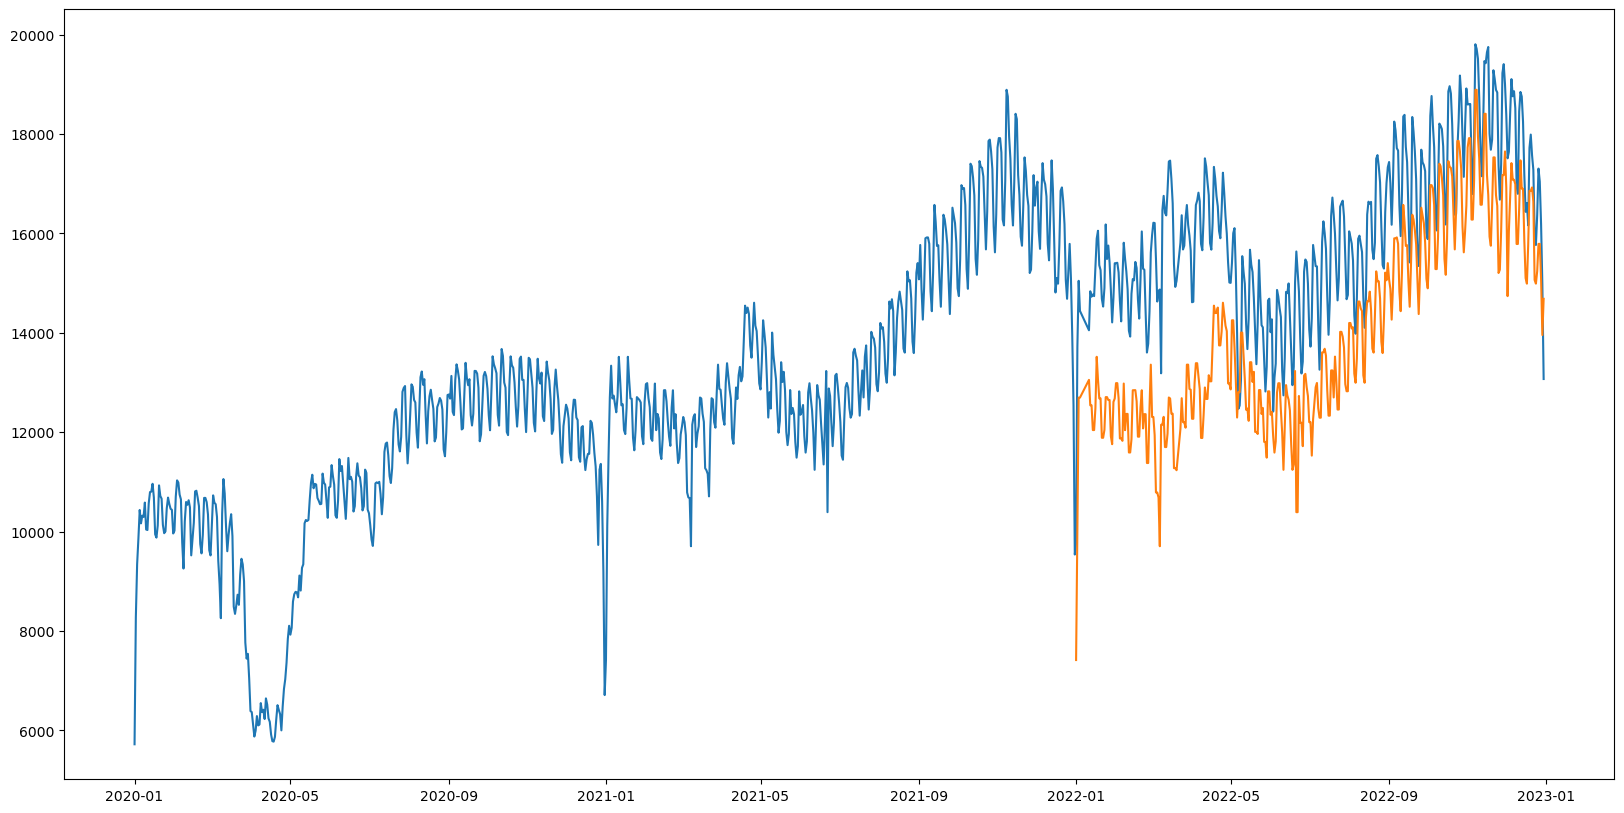

In [9]:
# Обучение настраиваемой модели дерева решений на обучающих данных
model = MyTreeReg(max_depth=60, min_samples_split=1, max_leafs=1000)
model.fit(train[['years', 'months','days', 'dayoftheweek']], train['y'])
# Прогнозирование на тестовых данных
y_pred = model.predict(test[['years', 'months','days','dayoftheweek']])
# Построение графика фактических и прогнозируемых значений для тестового периода
plt.figure(figsize=(20, 10))
plt.plot(data['ds'], data['y'], label='Actual')
plt.plot(data.query('ds >= "2022-01-01"')['ds'], y_pred, label='Forecast')
mean_absolute_percentage_error(y_pred, test['y'])

In [10]:
# Определение функции для обучения модели с различными конфигурациями параметров
def training(params):
    model = MyTreeReg(**params)
    model.fit(train[['years', 'months','days', 'dayoftheweek']], train['y'])
    prediction = pd.DataFrame(model.predict(test[['years', 'months','days', 'dayoftheweek']]), columns=['yhat'])
    actual = pd.DataFrame(test.y, columns=['y'])      
    return mean_absolute_percentage_error(actual['y'], prediction['yhat'])
param_grid = {
    'max_depth': np.arange(10, 501, 50),
    'min_samples_split': np.arange(1, 6, 1),
    'max_leafs': np.arange(1000, 5001, 500)
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Поиск оптимальных параметров
mapes = []
start_time = time()
for params in all_params:
    mapes.append(training(params))
best_params = all_params[np.argmin(mapes)]
print(best_params)
'MAPE', min(mapes)

KeyboardInterrupt: 

In [11]:
model = MyTreeReg(max_depth=60, min_samples_split=1, max_leafs=1000)
model.fit(data[['years', 'months','days', 'dayoftheweek']], data['y'])
start_date = '2023-01-01'
end_date = '2023-12-31'
dates_2023 = pd.date_range(start=start_date, end=end_date)
ds_2023 = pd.DataFrame({'ds': dates_2023})
ds_2023['ds'] = pd.to_datetime(ds_2023['ds'])
ds_2023['years'] = (ds_2023['ds']).dt.year
ds_2023['months'] = (ds_2023['ds'] ).dt.month
ds_2023['days'] = (ds_2023['ds']).dt.day
ds_2023['dayoftheweek'] = (ds_2023['ds']).dt.dayofweek
model.predict(ds_2023[['years', 'months','days', 'dayoftheweek']])

0       9772.000000
1      15046.000000
2      15046.000000
3      14441.000000
4      14051.000000
           ...     
360    17806.705882
361    17806.705882
362    16775.980769
363    16775.980769
364    16775.980769
Length: 365, dtype: float64

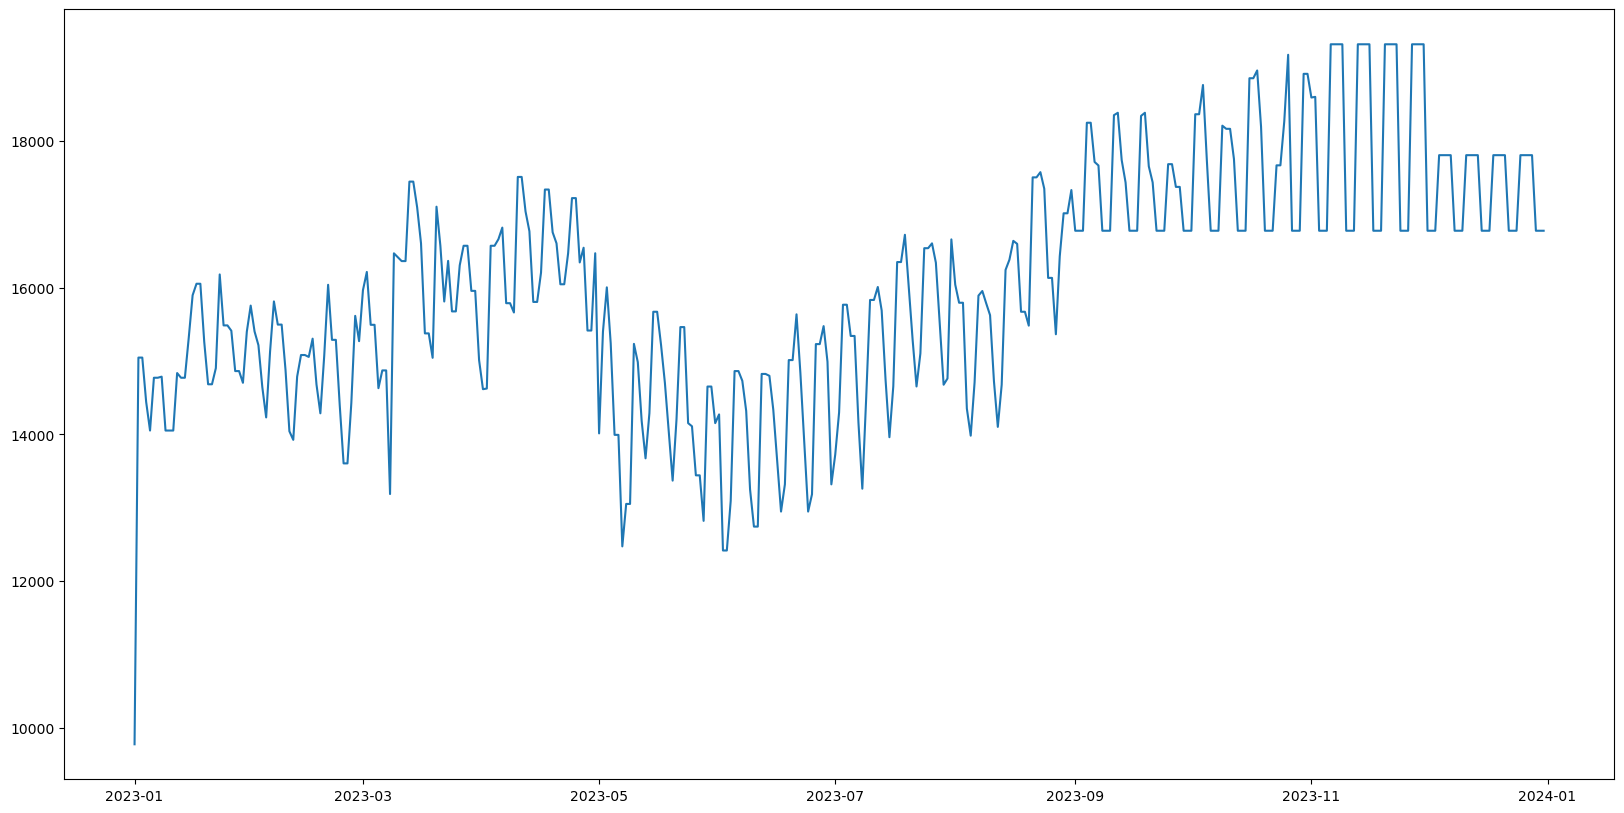

In [12]:
yhat = pd.DataFrame(model.predict(ds_2023[['years', 'months','days', 'dayoftheweek']]), columns=['yhat'])
ds_2023['y_hat'] = yhat
plt.figure(figsize=(20, 10))
plt.plot(ds_2023['ds'], ds_2023['y_hat'])

In [13]:
# Выгрузка
ds_2023[['ds', 'y_hat']].to_excel('output_d.xlsx', index=False)